In [8]:
# ==============================
# Primera celda - Importaciones
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeClassifier   # <-- Importación añadida
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import joblib

sns.set(style='whitegrid')
print("Todas las librerías cargadas.")


Todas las librerías cargadas.


In [9]:
# Configuración y carga de datos 
datos = pd.read_csv(filepath_or_buffer = "C:/RespaldoDB/breast-cancer.csv")
datos.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
# ==============================
# Justificación del algoritmo
# ==============================
"""
Se elige Regresión Ridge para clasificación (RidgeClassifier) debido a:
- Es un modelo lineal regularizado (L2) que previene sobreajuste.
- Es eficiente en datasets con muchas variables correlacionadas (multicolinealidad).
- Es robusto y sencillo de interpretar.
- Requiere pocos recursos computacionales y se optimiza rápidamente.

En este caso, se aplica para diagnosticar cáncer de mama en base a características numéricas,
clasificando en "Maligno" o "Benigno".
"""


'\nSe elige Regresión Ridge para clasificación (RidgeClassifier) debido a:\n- Es un modelo lineal regularizado (L2) que previene sobreajuste.\n- Es eficiente en datasets con muchas variables correlacionadas (multicolinealidad).\n- Es robusto y sencillo de interpretar.\n- Requiere pocos recursos computacionales y se optimiza rápidamente.\n\nEn este caso, se aplica para diagnosticar cáncer de mama en base a características numéricas,\nclasificando en "Maligno" o "Benigno".\n'

In [11]:
# ==============================
# Preprocesamiento y división de datos
# ==============================
# Conversión de variable objetivo a numérica
datos['diagnosis'] = datos['diagnosis'].map({'M': 1, 'B': 0})

# Separación en variables independientes (X) y dependiente (y)
X = datos.drop(columns=['id', 'diagnosis'])
y = datos['diagnosis']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño entrenamiento: {X_train.shape}")
print(f"Tamaño prueba: {X_test.shape}")


Tamaño entrenamiento: (455, 30)
Tamaño prueba: (114, 30)


In [12]:
# ==============================
# Diseño del modelo
# ==============================
"""
Diseño:
-------
Pipeline:
1. Imputación de valores faltantes con la media (SimpleImputer).
2. Escalado estandarizado (StandardScaler) para igualar rangos de las variables.
3. RidgeClassifier para clasificación binaria con regularización L2.

Optimización:
-------------
Se realiza GridSearchCV para encontrar el mejor valor de alpha,
con validación cruzada estratificada de 5 particiones.
"""

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('ridge', RidgeClassifier())
])

# Rango de valores alpha a evaluar
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')
grid.fit(X_train, y_train)

print(f"Mejor alpha: {grid.best_params_['ridge__alpha']}")
print(f"Mejor exactitud (validación cruzada): {grid.best_score_:.4f}")


Mejor alpha: 0.01
Mejor exactitud (validación cruzada): 0.9582


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

Matriz de confusión:


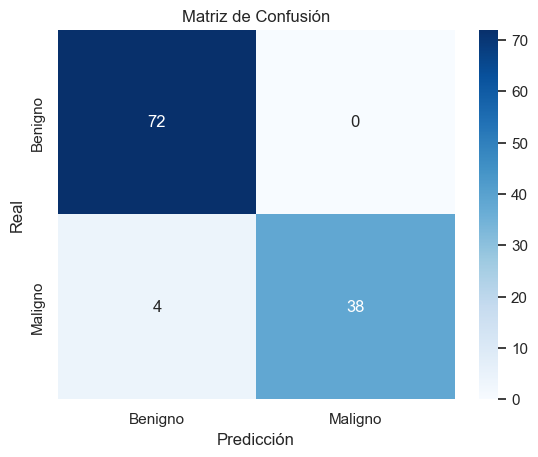

In [13]:
# ==============================
# Evaluación en el conjunto de prueba
# ==============================
y_pred = grid.predict(X_test)
y_proba = grid.decision_function(X_test)  # puntuación para ROC

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benigno", "Maligno"], yticklabels=["Benigno", "Maligno"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


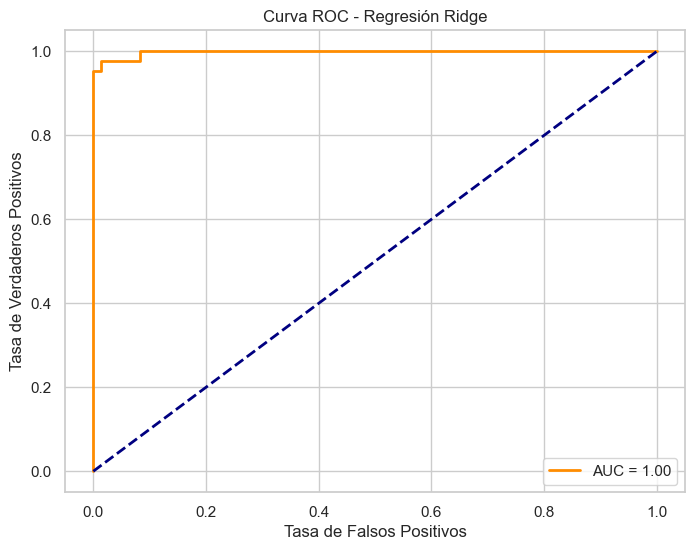

'\nInterpretación:\n---------------\nUn AUC cercano a 1 indica excelente capacidad de discriminación.\nEn este caso, el modelo presenta un AUC alto, lo que significa que distingue\nmuy bien entre tumores benignos y malignos.\n'

In [14]:
# ==============================
# Gráfica personalizada - Curva ROC
# ==============================
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Regresión Ridge')
plt.legend(loc="lower right")
plt.show()

"""
Interpretación:
---------------
Un AUC cercano a 1 indica excelente capacidad de discriminación.
En este caso, el modelo presenta un AUC alto, lo que significa que distingue
muy bien entre tumores benignos y malignos.
"""


In [15]:
# ==============================
# Guardar modelo entrenado
# ==============================
joblib.dump(grid.best_estimator_, "modelo_ridge_breast_cancer.pkl")
print("Modelo guardado como modelo_ridge_breast_cancer.pkl")


Modelo guardado como modelo_ridge_breast_cancer.pkl
